# Policy Gradient Graph Routing

In [1]:
import numpy as np
import torch
from time import time
from torch import nn, optim
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

from graph import Graph

In [2]:
# Define graph topology
g = Graph(2, [
    ('a', 'b'),
    ('a', 'b')
])

vtx_a = g.get_vertex_index('a')
vtx_b = g.get_vertex_index('b')

inp_size, out_size = g.get_mapping_shape()
print('Size of nn input layer:', inp_size)
print('Size of nn output layer:', out_size)

Size of nn input layer: 4
Size of nn output layer: 9


In [3]:
# Define model
hidden_size = 10
model = nn.Sequential(
    nn.Linear(inp_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, out_size),
    nn.Softmax(dim=1)
)
print(model)

Sequential(
  (0): Linear(in_features=4, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=9, bias=True)
  (3): Softmax(dim=1)
)


In [4]:
def train(batch_size, batch_number):
    print('=====================')

    optimizer = optim.Adam(model.parameters(), lr=0.003)
    total_rewards = np.zeros((batch_number,))
    for b in range(batch_number):
        optimizer.zero_grad()

        states = [g.get_random_state() for _ in range(batch_size)]
        state_tensor = torch.FloatTensor(states)

        action_probs = model(state_tensor)
        action_probs_np = action_probs.detach().numpy()
        actions = [np.random.choice(out_size, p=action_probs_np[c]) for c in range(batch_size)]
        action_tensor = torch.LongTensor(actions)

        rewards = [g.reward(s,a) for s,a in zip(states, actions)]
        reward_tensor = torch.FloatTensor(rewards)

        total_rewards[b] = np.mean(rewards)
        print("\rbatch: {} Average reward: {:.2f}".format(
                    b+1, total_rewards[b]), end="")

        logprob = torch.log(action_probs)
        selected_logprobs = reward_tensor * logprob[np.arange(len(action_tensor)), action_tensor]
        loss = -selected_logprobs.mean()

        # Calculate gradients
        loss.backward()
        # Apply gradients
        optimizer.step()
    
    print('')
    return total_rewards

def test():
    s = [vtx_a, vtx_b,
        vtx_a, vtx_b]
    action_probs = model(torch.FloatTensor([s])).detach().numpy()
    action = np.random.choice(out_size, p=action_probs[0])

    g.print_action_summary(s, action)

In [5]:
# Test untrained model (will likely choose bad actions)
test()

Agent 0 --> 0
Agent 1 is falsely wainting
Maximal number of agents on one road: 1


In [6]:
rewards = train(batch_size=200, batch_number=300)

batch: 300 Average reward: 1.00


In [7]:
# Test model after training (no collisions will occur)
test()

Agent 0 --> 1
Agent 1 --> 0
Maximal number of agents on one road: 1


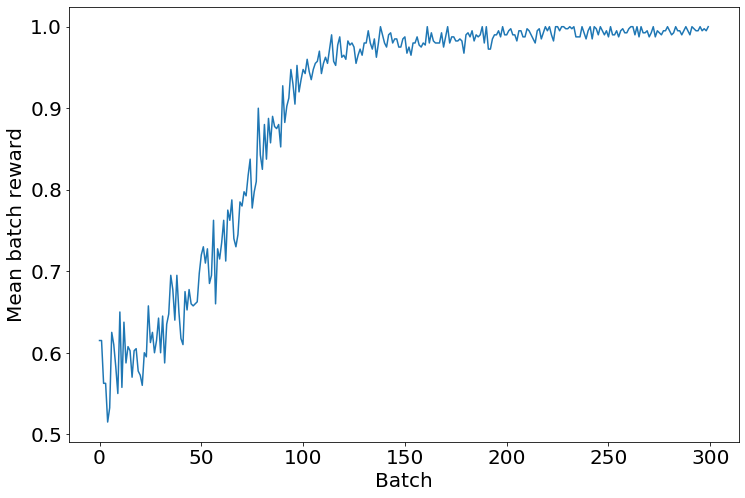

In [8]:
# Plot (mean) reward
plt.figure(figsize=(12,8))
plt.plot(rewards)
plt.ylabel('Mean batch reward')
plt.xlabel('Batch')
plt.show()